# Tutorial 3: Problems and Solvers

This notebook covers the basics of setting up and solving problems using Dedalus.

First, we'll import the public interface and suppress some of the logging messages:

In [1]:
from dedalus import public as de
import numpy as np
import matplotlib.pyplot as plt

de.logging_setup.rootlogger.setLevel('ERROR')
%matplotlib inline

## 3.1: Problems

### Problem formulations

Systems of differential equations in Dedalus are represented in the form:

$$\mathcal{M} \cdot \partial_t \mathcal{X} + \mathcal{L} \cdot \mathcal{X} = \mathcal{F}$$

where $\mathcal{X}$ is a state-vector of fields, $\mathcal{F}$ is a set of generally nonlinear expressions represented by operator trees, and $\mathcal{M}$ and $\mathcal{L}$ are matrices of linear differential operators.  This generalized form accomodates prognostic equations, diagnostic constraints, and boundary conditions using the tau method.

Dedalus includes a symbolic parser that takes equations and boundary conditions specified in plain text, and manipulates them into the above matrix form.  This form requires the equations to be first-order in time and coupled (Chebyshev) derivatives, and must only contain linear terms on the left-hand-side.  The entire RHS is parsed into an operator tree, and generally contains non-linear terms and linear terms that would couple different Fourier/parity modes, such as non-constant coefficients changing in these directions.

To create a problem object, you must provide a domain object and the names of the variables that appear in the equations.  Let's start setting up the KdV-Burgers equation on a finite interval:

$$\partial_t u + u \partial_x u = a \partial_{xx} u + b \partial_{xxx} u$$

The KdV-Burgers equation only has one primative field but is third-order in it's derivatives, so we'll have to introduce two extra fields to reduce the equation to first-order.  This problem will use the `IVP` class for initial value problems.  Separate classes are available for linear and nonlinear boundary value problems, and generalized eigenvalue problems.

In [2]:
# Create basis and domain
x_basis = de.Chebyshev('x', 1024, interval=(-2, 6), dealias=3/2)
domain = de.Domain([x_basis], np.float64)

# Create problem
problem = de.IVP(domain, variables=['u', 'ux', 'uxx'])

### Meta-data and preconditioning

Metadata for the problem variables can be specified through the `meta` attribute of the problem object, and indexing by variable name, axis, and property, respectively.  

The most common metadata to set here is the `dirichlet` option for Chebyshev bases, which performs a Dirichlet preconditioning / basis-recombination that sparsifies Dirichlet boundary conditions (interpolation at the Chebyshev interval endpoints), at the expense of a slightly increased problem bandwidth.  This can drastically improve performance for problems formulated with only Dirichlet boundary conditions.  Note that because the formulation is first-order in Chebyshev derivatives, this often includes what would be e.g. Neumann boundary conditions in a higher-order formulation.

Here we'll apply a Dirichlet preconditioning to all of our variables, for simplicity.

In [3]:
problem.meta[:]['x']['dirichlet'] = True

### Parameters and non-constant coefficients

Before adding the equations to the problem, we first add any parameters, defined as fields or scalars used in the equations but not part of the state vector of problem variables, to the `problem.parameters` dictionary.

For constant/scalar parameters, like we have here, we simply add the desired numerical values to the parameters dictionary.

In [4]:
problem.parameters['a'] = 2e-4
problem.parameters['b'] = 1e-4

For non-constant coefficients, we pass a field object with the desired data.  For linear terms, Dedalus currently only accepts NCCs that couple the Chebyshev direction, i.e. are constant along the Fourier/Parity directions, so that those directions remain linearly uncoupled.  To inform the parser that a NCC will not couple these directions, you must explicitly add some metadata to the NCC fields indiciating that they are constant along the Fourier/Parity directions.  

We don't have NCCs or separable dimensions here, but we'll sketch the process here anyways.  Consider a 3D problem on a Fourier (x), SinCos (y), Chebyshev (z) domain.  Here's how we would add a simple non-constant coefficient in z to a problem.

In [5]:
# ncc = domain.new_field(name='c')
# ncc['g'] = z**2
# ncc.meta['x', 'y']['constant'] = True
# problem.paramters['c'] = ncc

### Substitutions

To simplify equation entry, you can define substitution rules, which effectively act as string-replacement rules that will be applied during the parsing process.

Substitutions can be used to provide short aliases to quantities computed from the problem variables, and to define shortcut functions similart to python lambda functions, but with normal mathematical-function syntax.  Here's a sketch of how you might define some substitutions that could be useful for a fluid simulation.

In [6]:
## Substitution defining the kinetic energy density for a 3D fluid simulation.
## Here rho, u, v, and w would be variables in the simulation.

# problem.substitutions[‘KE_density’] = "rho * (u*u + v*v + w*w) / 2"

## Substitution defining the cartesian Laplacian of a field.
## Here A and Az are dummy variables that would be replaced by simulation variables in the equations.

# problem.substitutions[‘Lap(A, Az)’] = ‘dx(dx(A)) + dy(dy(A)) + dz(Az)’

### Equation entry

Equations and boundary conditions are then entered in plain text, optionally with conditions specifying which separable modes (indexed by `nx` and `ny` for separable axes named `x` and `y`, etc.) that equation applies to.

The parsing namespace basically consists of:
* The variables, parameters, and substitutions defined in the problem
* The axis names (`'x'` here), representing the individual basis grids
* The differential operators for each basis, named as e.g. `'dx'`
* The `differentiate`, `integrate`, and `interpolate` factories aliased as `'d'`, `'integ'`, and `'interp'`
* `'left'` and `'right'` as aliases to interpolation at the endpoints of the Chebyshev direction, if present
* Time and temporal derivatives as `'t'` and `'dt'`, by default (can be modified at IVP instantiation)
* Simple mathematical functions (logarithmic and trigonometric), e.g. `'sin'`, `'exp'`, ...

Let's see how to enter the equations and boundary conditions for our problem.

In [7]:
# Main equation, with linear terms on the LHS and nonlinear terms on the RHS
problem.add_equation("dt(u) - a*dx(ux) - b*dx(uxx) = -u*ux")
# Auxiliary equations defining the first-order reduction
problem.add_equation("ux - dx(u) = 0")
problem.add_equation("uxx - dx(ux) = 0")
# Boundary conditions
problem.add_bc('left(u) = 0')
problem.add_bc('left(ux) = 0')
problem.add_bc('right(ux) = 0')

## 3.2: Solvers

### Building a solver

Each problem type (initial value, linear and nonlinear boundary value, and eigenvalue) has a corresponding solver class that actually performs the solution or iterations for a corresponding problem.  Solvers are simply build using the `problem.build_solver` method.

For IVPs, we select a timestepping method when building the solver.  Several multistep and Runge-Kutta IMEX schemes are available.

In [8]:
solver = problem.build_solver(de.timesteppers.RK443)

### Setting initial conditions

The fields representing the problem variables can be accessed with a dictionary-like interface through the `solver.state` system.  For IVPs and nonlinear BVPs, initial conditions are set by directly modifying the state variable data before running a simulation.

In [9]:
# Reference local grid and state fields
x = domain.grid(0)
u = solver.state['u']
ux = solver.state['ux']
uxx = solver.state['uxx']

# Setup smooth triangle with support in (-1, 1)
n = 20
u['g'] = np.log(1 + np.cosh(n)**2/np.cosh(n*x)**2) / (2*n)
u.differentiate('x', out=ux)
ux.differentiate('x', out=uxx)

<Field 4786238072>

### Setting stop criteria

For IVPs, stop criteria for halting time evolution are specified by setting setting the `stop_iteration`, `stop_wall_time` (seconds since solver instantiation), and/or `stop_sim_time` attributes on the solver.  

Let's stop after 5000 iterations:

In [10]:
# Stop stopping criteria
solver.stop_sim_time = np.inf
solver.stop_wall_time = np.inf
solver.stop_iteration = 1000

### Solving/iterating a problem

Linear BVPs and EVPs are solved using the `solver.solve` method, nonlinear BVPs are iterated using the `solver.newton_iteration` method, and IVPs are iterated using the `solver.step` method with a provided timestep.

The logic controlling the main-loop of a Dedalus simulation occurs explicitly in the simulation script.  The `solver.ok` property can be used to halt an evolution loop once any of the specified stopping criteria have been met.  Let's timestep our problem until a halting condition is reached, copying the grid values of `u` every few iterations.  This should take less than a minute on most machines.

In [11]:
import time

# Setup storage
u_list = [np.copy(u['g'])]
t_list = [solver.sim_time]

# Main loop
dt = 1e-2
start_time = time.time()
while solver.ok:
    solver.step(dt)
    if solver.iteration % 5 == 0:
        u_list.append(np.copy(u['g']))
        t_list.append(solver.sim_time)
    if solver.iteration % 100 == 0:
        print('Completed iteration {}'.format(solver.iteration))
end_time = time.time()
print('Runtime:', end_time-start_time)

Completed iteration 100
Completed iteration 200
Completed iteration 300
Completed iteration 400
Completed iteration 500
Completed iteration 600
Completed iteration 700
Completed iteration 800
Completed iteration 900
Completed iteration 1000
Runtime: 4.605678081512451


Now let's make a space-time plot of the solution on the full dealiased grid:

Text(0.5,1,'A dispersive shock!')

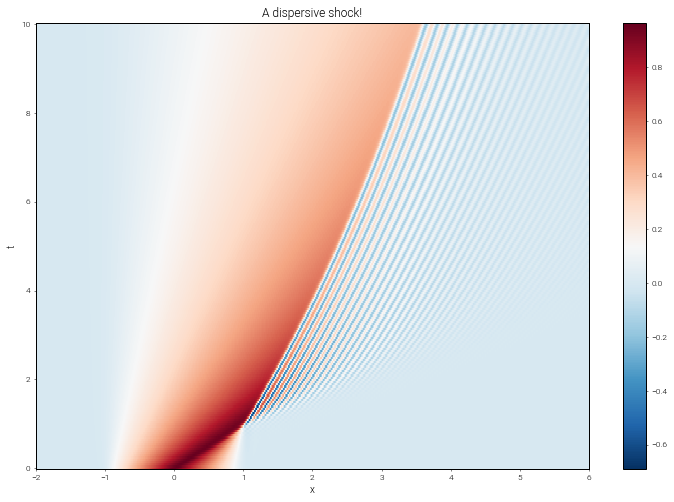

In [12]:
from dedalus.extras import plot_tools

# Convert storage to arrays
u_array = np.array(u_list)
t_array = np.array(t_list)

# Build space and time meshes
x_da = domain.grid(0, scales=domain.dealias)
xmesh, ymesh = plot_tools.quad_mesh(x=x_da, y=t_array)

# Plot
plt.figure(figsize=(12, 8))
plt.pcolormesh(xmesh, ymesh, u_array, cmap='RdBu_r')
plt.axis(plot_tools.pad_limits(xmesh, ymesh))
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('A dispersive shock!')